In [1]:
import numpy as np
import cv2

In [2]:
PATH = r'C:\\Users\\rjgle\\Documents\\Python Things\\ATRA differentiation\\2022.03.03 C2C12 ATRA differentiation\\ATRA 1 nM\\2022.03.03 A1 1-D.tif'

In [3]:
image = cv2.imread(PATH)

(960, 1280, 3)


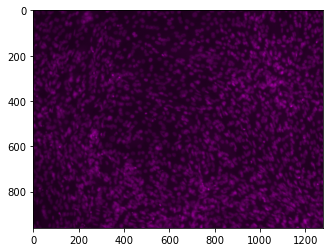

In [4]:
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image)

In [5]:
#The images are 960x1280
#We want to break them up in 64x64 sub-images
M = 64
N = 64
tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]

In [6]:
len(tiles)

300

In [7]:
#PATH TO EXPERIEMENT ONE
PATH_1 = 'C:\\Users\\rjgle\\Documents\\Python Things\\ATRA differentiation\\2022.03.03 C2C12 ATRA differentiation'
#PATH TO EXPERIMENT TWO
PATH_2 = 'C:\\Users\\rjgle\\Documents\\Python Things\\ATRA differentiation\\2022.03.21 C2C12 ATRA IGF1 Differentiation'

In [8]:
import os

#Break images up into 64x64 tiles
M = 64
N = 64

data = []

#Images in path 1
for file in os.listdir(PATH_1):
    f = os.path.join(PATH_1, file)
    if not f.endswith(".txt"):
        for filename in os.listdir(f):
                image_path = os.path.join(f, filename)
                if image_path.endswith(".tif"):
                    image = cv2.imread(image_path)
                    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
                    data.append(tiles)
                    
#Images in path 2
for file in os.listdir(PATH_2):
    f = os.path.join(PATH_2, file)
    if not f.endswith(".txt"):
        for filename in os.listdir(f):
                image_path = os.path.join(f, filename)
                if image_path.endswith(".tif"):
                    image = cv2.imread(image_path)
                    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
                    data.append(tiles)
                    
new_data = np.asarray(data)
new_data = np.reshape(new_data, (110100, 64, 64, 3))
new_data = np.transpose(new_data, (0,3,1,2))
new_data.shape

(110100, 3, 64, 64)

In [9]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch


# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(new_data)),
    test_size=0.15,
    random_state=14
)

# generate subset based on indices
train_split = Subset(new_data, train_indices)
test_split = Subset(new_data, test_indices)

#data_train = torch.IntTensor(train_split)
#data_test = torch.IntTensor(test_split)

In [10]:
train_dataloader = DataLoader(train_split, batch_size=32, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_split, batch_size=32, num_workers=2, shuffle=True)

In [11]:
#Utility functions to un-normalize and display an image
def imshow(img):
    plt.imshow(img) 

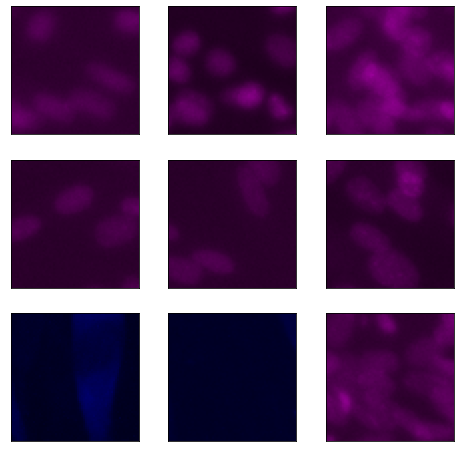

In [12]:
#Obtain one batch of training images
dataiter = iter(train_dataloader)
images = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx].transpose(1,2,0))

In [13]:
import torch.nn as nn
import torch.nn.functional as F

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x.float()))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x

#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [14]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cpu


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [16]:
#Epochs
n_epochs = 50

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_dataloader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.float(), images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_dataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

C:\Users\rjgle\anaconda3\envs\bigdata\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: -79811.875621
Epoch: 2 	Training Loss: -81566.737317
Epoch: 3 	Training Loss: -81649.297524
Epoch: 4 	Training Loss: -81649.303106
Epoch: 5 	Training Loss: -81649.314318
Epoch: 6 	Training Loss: -81649.315685
Epoch: 7 	Training Loss: -81649.346795
Epoch: 8 	Training Loss: -81649.390408
Epoch: 9 	Training Loss: -81649.403235
Epoch: 10 	Training Loss: -81649.391509
Epoch: 11 	Training Loss: -81649.395239
Epoch: 12 	Training Loss: -81649.407614
Epoch: 13 	Training Loss: -81649.392167
Epoch: 14 	Training Loss: -81649.409297
Epoch: 15 	Training Loss: -81649.419157
Epoch: 16 	Training Loss: -81649.417288
Epoch: 17 	Training Loss: -81649.418300
Epoch: 18 	Training Loss: -81649.424700
Epoch: 19 	Training Loss: -81649.426315
Epoch: 20 	Training Loss: -81649.434698
Epoch: 21 	Training Loss: -81649.435449
Epoch: 22 	Training Loss: -81649.432678
Epoch: 23 	Training Loss: -81649.348988
Epoch: 24 	Training Loss: -81649.331575
Epoch: 25 	Training Loss: -81649.445334
Epoch: 26